In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import json
from typing import List, Tuple

print('OpenCV Version: ', cv2.__version__)

OpenCV Version:  4.3.0


This time I'm going to try shape matching the contours using cv2.matchShapes. This uses the Hu Moments to compare the contours.

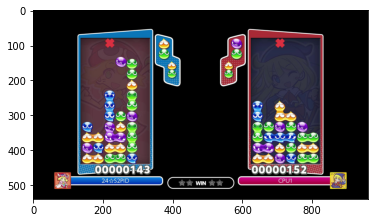

In [3]:
im = Image.open('test-images/amitie_witch3.jpg')
im = im.resize((im.width // 2, im.height // 2))
im = np.array(im)
plt.imshow(im)
plt.show()

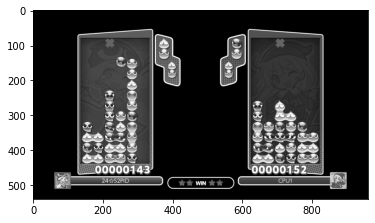

In [4]:
# Grayscale
im_gray = np.dot(im[...,:3], [0.2989, 0.5870, 0.1140])
im_gray = im_gray.astype(np.uint8)
plt.imshow(im_gray, cmap='gray')
plt.show()

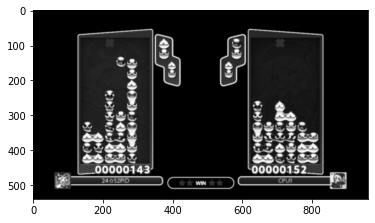

In [5]:
# Use a lookup table to apply contrast stretching to dark regions
xp = [0, 64, 128, 192, 255]
fp = [0, 32, 64, 240, 255]
x = np.arange(256)
table = np.interp(x, xp, fp).astype('uint8')
new_im = table[im_gray]
new_im = cv2.GaussianBlur(new_im, (5, 5), 0)
plt.imshow(new_im, cmap='gray')
plt.show()

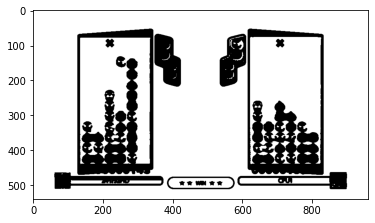

In [6]:
# Get a mask for dark regions
mask = np.zeros_like(new_im)
mask[new_im < 40] = 255
plt.imshow(mask, cmap='gray')
plt.show()

[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


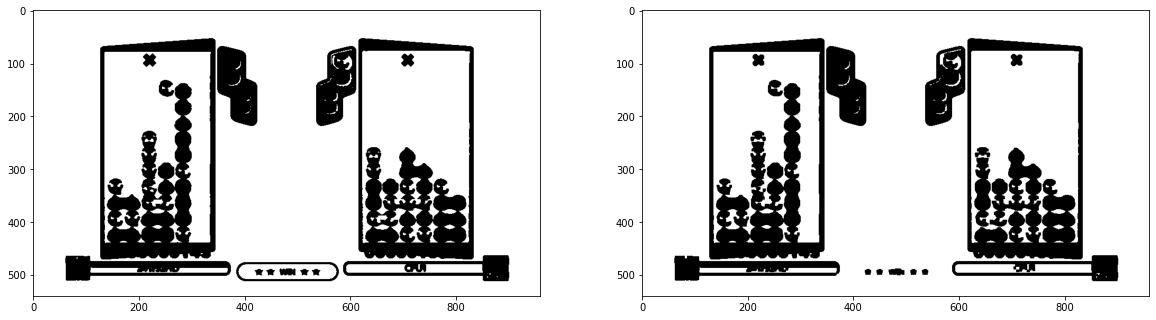

In [7]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
print(kernel)
closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
fig, ax = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(20)
ax[0].imshow(mask, cmap='gray')
ax[1].imshow(closed, cmap='gray')
plt.show()

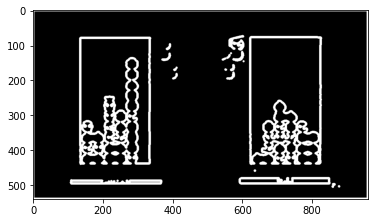

In [8]:
contours, hierarchy = cv2.findContours(closed, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
# Only keep contours that outline white regions
hierarchy = hierarchy.reshape(-1, 4)
top_inds = np.argwhere(hierarchy[:, 3] == -1).reshape(-1)
contours = [contours[i] for i in top_inds]
hierarchy = hierarchy[top_inds]

closed_copy = np.zeros_like(closed)
cv2.drawContours(closed_copy, contours, -1, 255, 5)
plt.imshow(closed_copy, cmap='gray')

In [9]:
# Find bounding rects for each contour
rects = np.array([cv2.boundingRect(contour) for contour in contours])
rect_contour = [np.array([[[x, y]], [[x, y + h]], [[x + w, y + h]], [[x + w, y]]]) for x, y, w, h in rects]

## cv2.matchShapes()

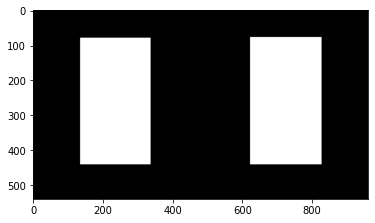

In [10]:
# Manually determine the correct contours
closed_copy = np.zeros_like(closed)
cv2.drawContours(closed_copy, rect_contour, 47, 255, -1) # Player 1
cv2.drawContours(closed_copy, rect_contour, 48, 255, -1) # Player 2
plt.imshow(closed_copy, cmap='gray')

In [11]:
# Defaults
p1_field_contour = rect_contour[47]
p2_field_contour = rect_contour[48]

contour_data = {
    'p1_field': p1_field_contour.tolist(),
    'p2_field': p2_field_contour.tolist()
}

json.dump(contour_data, open('player_field.json', 'w'))

In [14]:
field_data = json.load(open('player_field.json'))
p1_field_contour = np.array(field_data['p1_field'])
p2_field_contour = np.array(field_data['p2_field'])

In [15]:
contour_ind_set = set()
p1_field_matches = [cv2.matchShapes(p1_field_contour, contour, cv2.CONTOURS_MATCH_I1, 0) for contour in contours]
partition = np.argpartition(p1_field_matches, 1)
contour_ind_set.add(partition[0])
contour_ind_set.add(partition[1])

p2_field_matches = [cv2.matchShapes(p2_field_contour, contour, cv2.CONTOURS_MATCH_I1, 0) for contour in contours]
partition = np.argpartition(p2_field_matches, 1)
contour_ind_set.add(partition[0])
contour_ind_set.add(partition[1])

contour_ind_set = list(contour_ind_set)

contour0 = contours[contour_ind_set[0]]
contour1 = contours[contour_ind_set[1]]
contour0_min_x = np.amin(np.array(contour0).reshape(-1, 2)[:, 0])
contour1_min_x = np.amin(np.array(contour1).reshape(-1, 2)[:, 0])

# Contour on the left is p1, contour on the right is p2
if contour0_min_x < contour1_min_x:
    p1_field = contour0
    p2_field = contour1
else:
    p1_field = contour1
    p2_field = contour0

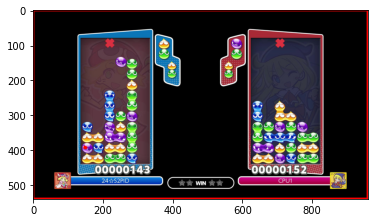

In [17]:
im_copy = np.copy(im)
cv2.drawContours(im_copy, [p1_field], 0, (255, 0, 0), 5)
cv2.drawContours(im_copy, [p2_field], 0, (255, 0, 0), 5)
plt.imshow(im_copy, cmap='viridis')

ok nah. seems like opencv shape matches the board field to the game background.